In [52]:
import numpy as np
import imp
import sys
import os
import time
sys.path.append(os.path.expanduser('~/quantum-ml/nanowire_model'))
import copy
import potential_profile

import multiprocessing as mp

import markov
import physics
import thomas_fermi
import mask
import tunneling
import exceptions

imp.reload(tunneling)
imp.reload(markov)
imp.reload(physics)
imp.reload(thomas_fermi)
imp.reload(mask)
imp.reload(potential_profile)
imp.reload(exceptions)

physics_model = {}
# multiple of eV
physics_model['E_scale'] = 1
# multiple of nm
physics_model['dx_scale'] = 1

physics_model['kT'] = 1000e-6

b1 = [-200e-3,-0.3,0.1,1]
d = [200e-3,0.0,0.1,1]
b2 = [-200e-3,0.3,0.1,1]
physics_model['list_b'] = [b1,d,b2]
x = np.linspace(-1,1,100)
physics_model['x'] = x
physics_model['V'] = potential_profile.V_x_wire(x,[b1,d,b2])

physics_model['K_onsite'] = 5e-3
physics_model['sigma'] = x[1] - x[0]
physics_model['x_0'] = 0.1*(x[1] - x[0])
physics_model['mu_l'] = (100.0e-3,100.1e-3)
physics_model['battery_weight'] = 10
physics_model['short_circuit_current'] = 1

graph_model = (5,1)
tf_strategy = 'simple'

#timeit my_phys = physics.Physics(physics_model)
#%lprun -f physics.Physics.__init__ my_phys = physics.Physics(physics_model)

#timeit graph = markov.Markov(graph_model,physics_model,tf_strategy)
#%lprun -f thomas_fermi.ThomasFermi.tf_solver_fixed_mu graph = markov.Markov(graph_model,physics_model,tf_strategy)

st = time.time()
graph = markov.Markov(graph_model,physics_model,tf_strategy)
print(graph.find_n_dot_estimate())
print(graph.find_start_node())
print(graph.recalculate_graph)
graph.generate_graph()
print(graph.get_current())
print(graph.get_charge_state())
print("time",time.time()-st)



1
(0, 3, 0)
True
0.00250075335873
(3,)
time 0.07898283004760742


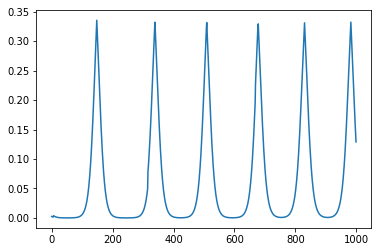

In [53]:
V_d_vec = np.linspace(200e-3,250e-3,1000)
I_vec = np.zeros(1000)
for i in range(len(V_d_vec)):
    d[0] = V_d_vec[i]
    physics_model['list_b'] = [b1,d,b2]
    V = potential_profile.V_x_wire(x,physics_model['list_b'])
    physics_model['V'] = potential_profile.V_x_wire(x,[b1,d,b2]) 
    I_vec[i] = np.sum(calculate_current((graph,physics_model))['current'])
 
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(I_vec)

In [42]:
graph.tf.attempt_rate_scale/1e14

5.9309696064001614

In [ ]:
plt.plot(graph.tf.V)

In [4]:
def calculate_current(param):
    graph = param[0]
    physics_model = param[1]
    try:
        graph.physics = physics_model
        graph.tf.__init__(physics_model)
        graph.find_n_dot_estimate(fix_mask=False)
        graph.find_start_node()
        graph.generate_graph()
        return graph.get_output()
    except exceptions.NoBarrierState:
        output = {}
        output['current'] = graph.tf.short_circuit_current
        output['charge_state'] = (0,)
        output['prob_dist'] = (0,)
        output['num_dot'] = 0
        output['state'] = 'ShortCircuit'
        return output
    except exceptions.InvalidChargeState:
        output = {}
        output['current'] = 0
        output['charge_state'] = (0,)
        output['prob_dist'] = (0,)
        output['num_dot'] = 0
        output['state'] = 'NoDot'
        return output
    
def calculate_curr_parr(physics_model):
    graph_model = (10,1)
    tf_strategy = 'simple_iter'
    
    try: 
        graph = markov.Markov(graph_model,physics_model,tf_strategy)
        graph.physics = physics_model
        graph.tf.__init__(physics_model)
        graph.find_n_dot_estimate(fix_mask=False)
        graph.find_start_node()
        graph.generate_graph()
        I = graph.get_output()
        del graph
        return I
    except exceptions.NoBarrierState:
        return graph.tf.short_circuit_current

In [ ]:
XX,YY = np.meshgrid(V_d_vec,V_d_vec)
plt.pcolor(XX,YY,np.array([x['current'] if x['current'] != None else 0.0 for x in output_vec]).reshape((N_v,N_v)),\
           cmap='coolwarm',vmax=1e-3)
plt.xlabel(r'$V_{d1} (V)$',fontsize=16)
plt.ylabel(r'$V_{d2} (V)$',fontsize=16)
cbar = plt.colorbar()
cbar.set_label("Current (arb. units)",fontsize=16)

In [ ]:
XX,YY = np.meshgrid(V_d_vec,V_d_vec)
def map_state_to_color(param):
    (state,num_dot) = param
    if state == 'QPC':
        return 0
    elif state == 'Dot' and num_dot == 1:
        return 1
    elif state == 'Dot' and num_dot == 2:
        return 2
    elif state == 'ShortCircuit':
        return 3
    else:
        return 4
C = [map_state_to_color(x) for x in zip([y['state'] for y in output_vec],[y['num_dot'] for y in output_vec])]
import matplotlib as mpl
my_cmap = mpl.colors.ListedColormap([[0., .4, 1.], [0., .8, 1.],
                                  [1., .8, 0.], [1., .4, 0.]])
C_new = [C[N_v*i : N_v*(i+1)] for i in range(N_v)]
plt.pcolor(XX,YY,C_new,cmap = my_cmap,alpha=0.9)
plt.xlabel(r'$V_{d1} (V)$',fontsize=16)
plt.ylabel(r'$V_{d2} (V)$',fontsize=16)
cbar = plt.colorbar(cmap=my_cmap,ticks=[0,1,2,3])
cbar.set_ticklabels(["QPC","SingleDot","DoubleDot","ShortCircuit"])
cbar.set_ticks([0.5,1.5,2.5,3.5])

In [ ]:
plt.pcolor(XX,YY,np.array([np.sum(x['charge_state']) if x['charge_state'] != None else 0.0 for x in output_vec]).reshape((N_v,N_v)),alpha=0.9)
plt.xlabel(r'$V_{d1} (V)$',fontsize=16)
plt.ylabel(r'$V_{d2} (V)$',fontsize=16)
cbar = plt.colorbar()
cbar.set_label('Total Charge',fontsize=16)